# Allison Bernstein - Austin Animal Shelter Outcomes
_______

## Introduction

For my project, I am focusing on an analysis of outcomes from animal shelters in Austin, Texas. There are 3 data sets included, data from animal intakes, and data from animal outcomes, and lastly a merged data set from 2013-2017. The datasets can be found here: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes . The goal of my project is to conduct a prediction study to determine what factors may impact adoptions. This will largely be done by finding any correlations between certain variables and likelihood of being adopted, along with time take to be adopted.. In other words, are certain animals more likely to get adopted/adopted more quickly than others? If so, what factors contribute to this... do certain breeds gets adopted more than others? certain genders? etc. Initially I wavered on whether to do a regression or classification analysis. At first I had anticipated primarily using time taken to adopt as the dependent variable, and given that that is a continous variable so I should do a regression study. However, given that much of my data is categorical, I figured a study filled with only bar graphs wouldn't be too interesting, so I decided to go with a classification study to determine likelihood of adoption.

## Data

The data from Austin Animal Shelters contains information on roughly 80,000 animals taken into the shelters from 2013-2017. Not all variables will be used, as some do not provide much relevance (i.e name, location found). Additionally, after cleaning the data, there will be roughly half the amount of data points. The following variables will be used in my study:

* Time in shelter (in days) - this is the duration of time (in days) that the animal was in the shelter. Fortunately, the publisher of the dataset has aready taken the data points from intakes and outtakes and calculated the duration.
* Age- ages are recorded both at the time of intake, and at the time of release.
* Animal ID- this will be used to match each individual animal in the intake dataset with the corresponding outcome dataset
* Animal type- this will differentiate each type of animal (cat vs. dog)
* Breed- specific breed of the type of animal
* Color- color of the animals fur. At first I considered not using this variable, but thought it may be interesting to see if animals of a certain color tend to be adopted more quickly than others.
* Intake condition: The general health condition of the animal (normal, sick, injured, aged)
* Sex upon intake: This not only refers to gender, but also if the animal has been spayed/neutered. This variable will actually be used for 2 tests, 1 being analyzing male vs. female adoptions, and the other being analyzing if there appears to be preference on an animal being spayed/neutered.
* Intake type- cause of the animal being in the shelter (ex: surrendered by owner, stray, etc.)
* Outcome type- this determines if the animal was transfered, adopted, returned to owner, euthanized, etc. 

## Data Cleaning
Fortunately for me, the publisher of this data has created a combined data set. The merged data set contains all of the variables from the intakes and outcomes, and merged them into 1 dataset by using the animal_id. Additionally, a new field was added by the publisher named "time_in_shelter_days" which is the amount of days the animal stayed in the shelter by using the datestamp from intake vs. datestamp from outcome. Likewise, the publisher also mostly converted fields to their appropriate data type (age=int, time_in_shelter_days= int, etc). I got relatively lucky with this dataset as the publisher had really performed a lot of data transformations/cleaning already, however for my particular study I still needed to perform more cleaning and transformations.

**Data Filtering/Cleaning**
1. Dropping irrelevant/unnecessary columns that do not pertain to my particular goal, or tend to be redundant. For example, considering that the number of days in the shelter is already recorded, the exact day, hour, month, etc. of the intake/outcome is not of much use. Additionally, considering we already have age as a variable, date of birth is not of much use.
2. Filtering animal type. For the purposes of this project, I am only going to be focusing on the data for dogs and cats, and will be dropping the "other" field. There are so few data points for other animals, that any results would not provide anything overly insightful in terms of adoption rates.
3. Reducing number of categories. Many of the categories such as breed and color, have upwards of 300 different categories. In order to make the data more managable, I will have to find ways to reduce these categories. Examples of this would be seperating breeds into mix/purebreed. Additionally, I grouped color into more vague categories. For example, black/tan means the animal is primarily black with some tan, so that would be categorized as black, whereas tan/black would be categorized as tan.
4. Converting categorical data to numerical. Mostly mapping will be used to give some categorical data actual numeric values to work better in the decision tree.
5. Creating columns that better represent binary data. The decision tree doesn't work very well with categorical data that is non-binary, so columns will be created such as Male: Y or N, Young: Y or N, Healthy: Y or N.

Note: It may seem like many of the columns are being removed, however of the 41 columns, many are repetitive or not particularly useful.

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.linear_model
import patsy
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [235]:
df = pd.read_csv('aac_intakes_outcomes.csv')
del df['date_of_birth'], df['outcome_subtype'], df['age_upon_outcome_(days)'],df['age_upon_outcome_age_group'],df['outcome_datetime'],df['outcome_year'],df['outcome_monthyear'],df['outcome_hour'],df['age_upon_intake_age_group'],df['outcome_weekday'],df['outcome_number'],df['dob_month'],df['dob_year'],df['intake_datetime'],df['intake_year'],df['dob_monthyear'],df['count'],df['intake_monthyear'],df['intake_weekday'],df['intake_hour'],df['intake_number'],df['time_in_shelter'],df['found_location'],df['animal_id_intake'],df['sex_upon_outcome'] 
df['Adopted'] = np.where(df['outcome_type']=='Adoption', 'Yes', 'No')
df.rename(columns = {'age_upon_intake_(years)':'age_upon_intake_years','age_upon_intake_(days)':'age_upon_intake_days'}, inplace = True)
other = df[df['animal_type'] == 'Other'].index
bird = df[df['animal_type'] == 'Bird'].index
df.drop(other, inplace=True)
df.drop(bird, inplace=True)
drop_e =df[df['intake_type'] =='Euthanasia Request'].index
df.drop(drop_e, inplace=True)
mapping_animal = {'Dog':0,'Cat':1}
df.replace({'animal_type': mapping_animal}, inplace=True)
mapping_gender = {'Neutered Male':1,'Intact Male':2, 'Spayed Female':3,'Intact Female':4, 'Unknown':5}
df.replace({'sex_upon_intake': mapping_gender}, inplace=True)
color_dict = {}
for color in df.color:
    color_dict.update({color : color.split('/')[0]})
df.color = df.color.map(color_dict )
#key ... yellow/tan = 1, tricolor = 2, brown =3, black = 4, white = 5, gray = 6, red/orange = 7
mapping_color = {'Yellow':1, 'Tricolor':2, 'Brown':3, 'Black':4, 'White':5, 'Brown Tabby':3,'Tan':1, 'Gold':1, 'Sable':2, 'Blue Merle':2, 'Gray':6, 'Cream':5,'Red':7,'Gray Tabby':6,'Brown Merle':3,'Tortie':2,'Black Smoke':4,'Orange Tabby':7,'Blue Cream':6,'Lynx Point':5, 'Red Merle':7,'Calico':2,'Blue':6,'Lilac Point':5,'Black Brindle':4, 'Chocolate':3, 'Blue Point':6, 'Silver Tabby':6, 'Brown Brindle':3,'Seal Point':2,'Flame Point':5,'Blue Tick':6, 'Apricot':7,'Buff':1, 'Chocolate Point':3, 'Black Tabby':4, 'Silver': 6, 'Blue Tabby':6, 'Cream Tabby':5,'Torbie':2,'Calico Point':2,'Tortie Point':2,'Fawn':1,'Red Tick':2,'Liver':3,'Black Tiger':4,'Orange':7,'Blue Tiger':6,'Yellow Brindle':1,'Brown Tiger':3,'Blue Smoke':6,'Ruddy':2,'Liver Tick':3,'Agouti':6, 'Silver Lynx Point':6, 'Orange Tiger':7, 'Pink':5}
df.replace({'color': mapping_color}, inplace=True)
df = df.dropna(axis = 0, how ='any') 
mapping_intake_type={'Stray':1,'Public Assist':2,'Owner Surrender':3,'Euthanasia Request':4}
df.replace({'intake_type': mapping_intake_type}, inplace=True)
mapping_condition={'Normal':1,'Injured':2,'Aged':3,'Sick':4,'Other':5,'Feral':6,'Pregnant':7,'Nursing':7}
df.replace({'intake_condition': mapping_condition}, inplace=True)
age_group={}
for age in df.age_upon_intake_years:
    if age < 1:
        age_group.update({age:'<1'})
    elif (age <= 5):
        age_group.update({age:'1-5'})
    elif (age <= 10):
        age_group.update({age:'6-10'})
    elif (age <= 15):
        age_group.update({age:'11-15'})
    elif (age <= 20):
        age_group.update({age:'16-20'})
    else:
        age_group.update({age:'20+'})
df['age_group'] = df.age_upon_intake_years.map(age_group)
mapping_agegroup={'<1':1,'1-5':2,'6-10':3,'11-15':4,'16-20':5,'20+':6}
df.replace({'age_group': mapping_agegroup}, inplace=True)
q = df["time_in_shelter_days"].quantile(0.99)
df =df[df["time_in_shelter_days"] < q]
df.count()

age_upon_outcome            73912
animal_id_outcome           73912
outcome_type                73912
age_upon_outcome_(years)    73912
outcome_month               73912
age_upon_intake             73912
animal_type                 73912
breed                       73912
color                       73912
intake_condition            73912
intake_type                 73912
sex_upon_intake             73912
age_upon_intake_days        73912
age_upon_intake_years       73912
intake_month                73912
time_in_shelter_days        73912
Adopted                     73912
age_group                   73912
dtype: int64

In [236]:
young={}
for age_group in df.age_group:
    if age_group == 1 or age_group==2:
        young.update({age_group:'yes'})
    else:
        young.update({age_group:'no'})
df['young'] = df.age_group.map(young)
mapping_young={'yes':1,'no':0}
df.replace({'young': mapping_young}, inplace=True)
#key ... yellow/tan = 1, tricolor = 2, brown =3, black = 4, white = 5, gray = 6, red/orange = 7
light_fur={}
for color in df.color:
    if color == 1 or color==5 or color==6 or color==7:
        light_fur.update({color:'yes'})
    else:
        light_fur.update({color:'no'})
df['Light_Fur'] = df.color.map(light_fur)
mapping_light_fur={'yes':1,'no':0}
df.replace({'Light_Fur': mapping_light_fur}, inplace=True)
df.head()
male={}
for sex in df.sex_upon_intake:
    if sex == 1 or sex==2:
        male.update({sex:'yes'})
    else:
        male.update({sex:'no'})
df['Male'] = df.sex_upon_intake.map(male)
mapping_male={'yes':1,'no':0}
df.replace({'Male': mapping_male}, inplace=True)
df.head()
neut_spay={}
for val in df.sex_upon_intake:
    if val == 1 or val==3:
        neut_spay.update({val:'yes'})
    else:
        neut_spay.update({val:'no'})
df['Neutered/Spayed'] = df.sex_upon_intake.map(neut_spay)
mapping_neut_spay={'yes':1,'no':0}
df.replace({'Neutered/Spayed': mapping_neut_spay}, inplace=True)
df.head()
stray={}
for x in df.intake_type:
    if x == 1 :
        stray.update({x:'yes'})
    else:
        stray.update({x:'no'})
df['Stray'] = df.intake_type.map(stray)
mapping_stray={'yes':1,'no':0}
df.replace({'Stray': mapping_stray}, inplace=True)
df.head()
health={}
for y in df.intake_condition:
    if x == 1 :
        health.update({y:'yes'})
    else:
        health.update({y:'no'})
df['Healthy'] = df.intake_condition.map(health)
mapping_healthy={'yes':1,'no':0}
df.replace({'Healthy': mapping_healthy}, inplace=True)

pure= {}
for z in df.breed:
    if '/' in z or 'Mix' in z:
        pure.update({z:'no'})
    else:
        pure.update({z:'yes'})
df['Pure_Breed'] = df.breed.map(pure_breed)
mapping_pure={'yes':1,'no':0}
df.replace({'Pure_Breed': mapping_pure}, inplace=True)
df

,age_upon_outcome,animal_id_outcome,outcome_type,age_upon_outcome_(years),outcome_month,age_upon_intake,animal_type,breed,color,intake_condition,...,time_in_shelter_days,Adopted,age_group,young,Light_Fur,Male,Neutered/Spayed,Stray,Healthy,Pure_Breed
0,10 years,A006100,Return to Owner,10.000000,12,10 years,0,Spinone Italiano Mix,1,1,...,0.588194,No,3,0,1,1,1,1,1,0
1,7 years,A006100,Return to Owner,7.000000,12,7 years,0,Spinone Italiano Mix,1,1,...,1.259722,No,3,0,1,1,1,0,1,0
2,6 years,A006100,Return to Owner,6.000000,3,6 years,0,Spinone Italiano Mix,1,1,...,1.113889,No,3,0,1,1,1,0,1,0
3,10 years,A047759,Transfer,10.000000,4,10 years,0,Dachshund,2,1,...,4.970139,No,3,0,0,1,1,0,1,1
4,16 years,A134067,Return to Owner,16.000000,11,16 years,0,Shetland Sheepdog,3,2,...,0.119444,No,5,0,0,1,1,0,1,1
5,15 years,A141142,Return to Owner,15.000000,11,15 years,0,Labrador Retriever/Pit Bull,4,3,...,0.870833,No,4,0,0,0,1,1,1,0
6,15 years,A163459,Return to Owner,15.000000,11,15 years,0,Miniature Schnauzer Mix,4,1,...,0.178472,No,4,0,0,0,0,1,1,0
7,15 years,A165752,Return to Owner,15.000000,9,15 years,0,Lhasa Apso Mix,3,1,...,0.213194,No,4,0,0,1,1,1,1,0
8,15 years,A178569,Return to Owner,15.000000,3,15 years,0,Shetland Sheepdog Mix,5,1,...,6.258333,No,4,0,1,1,1,0,1,0
9,18 years,A189592,Return to Owner,18.000000,9,18 years,0,Shetland Sheepdog Mix,3,1,...,0.054167,No,5,0,0,0,1,1,1,0


# Data Visualization

## Adopted vs. Not Adopted by groups

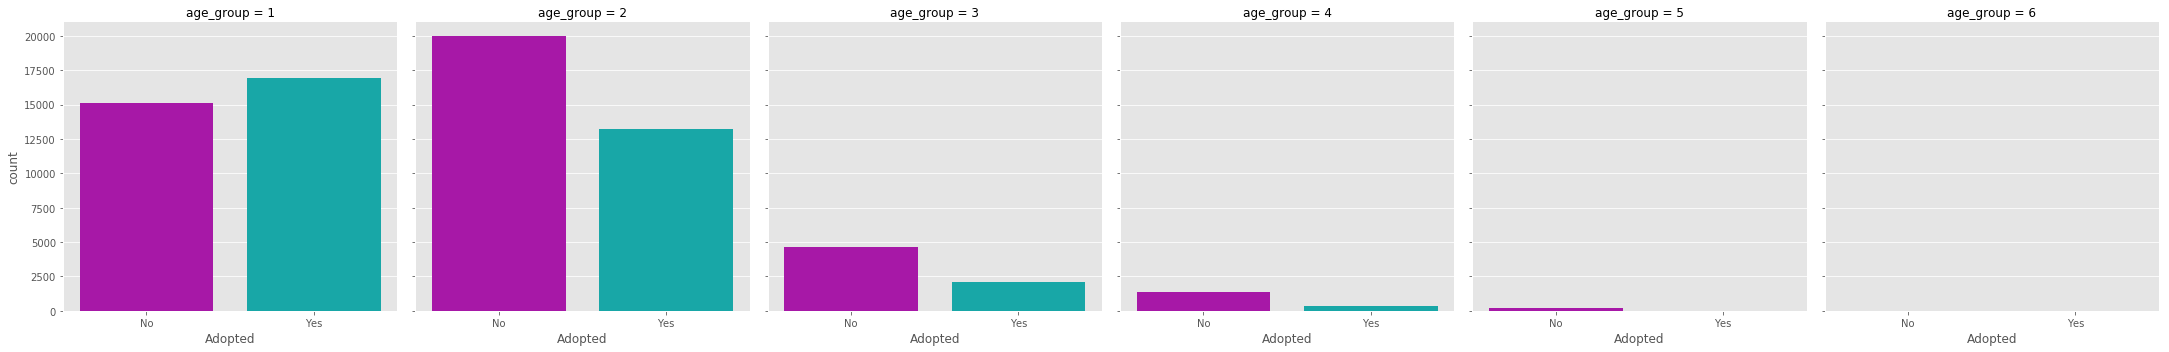

In [239]:
sns.catplot('Adopted', col = 'age_group', kind = 'count', data = df, palette=sns.color_palette(['m', 'c']))

#### age <1 = 1,   ages 1-5 =2,   ages 6-10 = 3,  ages 11-15 =4,  ages 16-20 = 5,   age 20+'=6

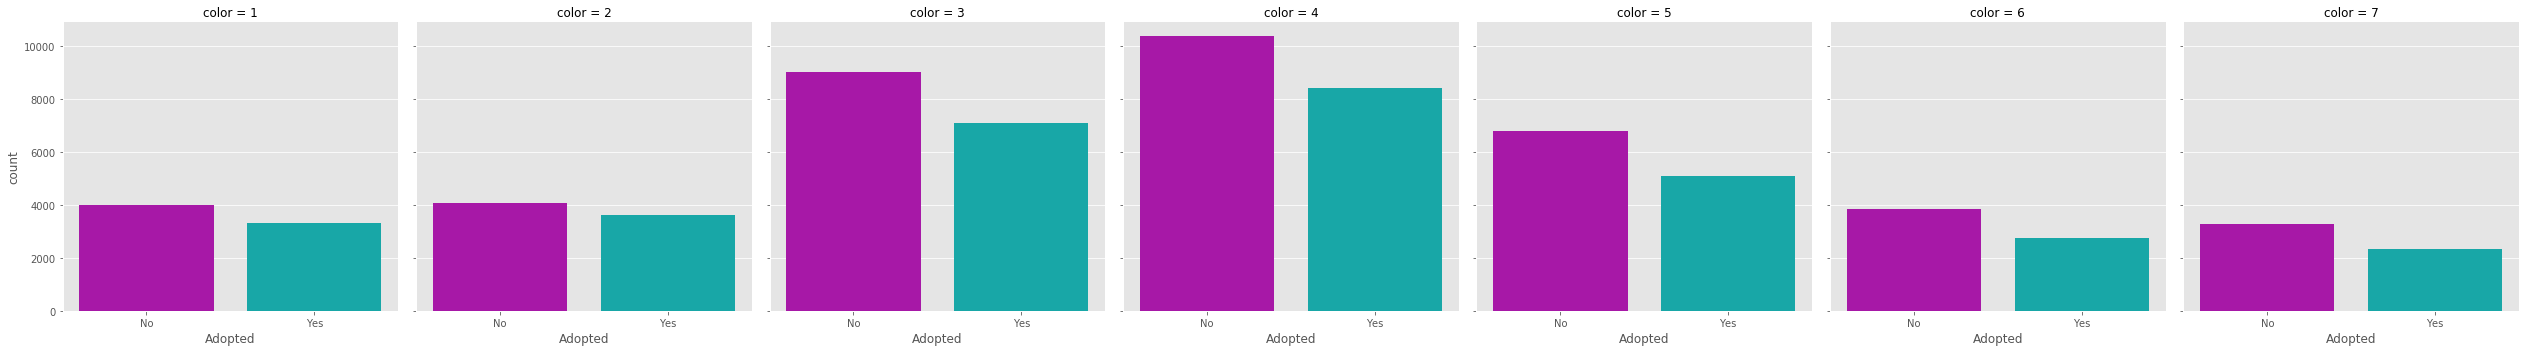

In [240]:
sns.catplot('Adopted', col = 'color', kind = 'count', data = df, palette=sns.color_palette(['m', 'c']))


#### key ... yellow/tan = 1, tricolor = 2, brown =3, black = 4, white = 5, gray = 6, red/orange = 7


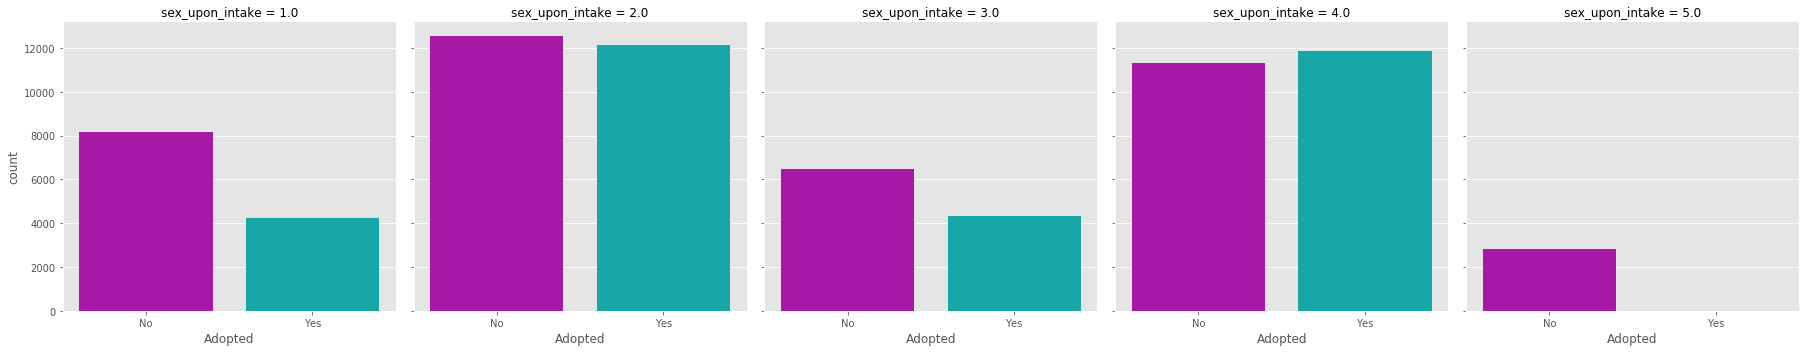

In [241]:
sns.catplot('Adopted', col = 'sex_upon_intake', kind = 'count', data = df, palette=sns.color_palette(['m', 'c']))


#### 'Neutered Male':1,'Intact Male':2, 'Spayed Female':3,'Intact Female':4, 'Unknown':5

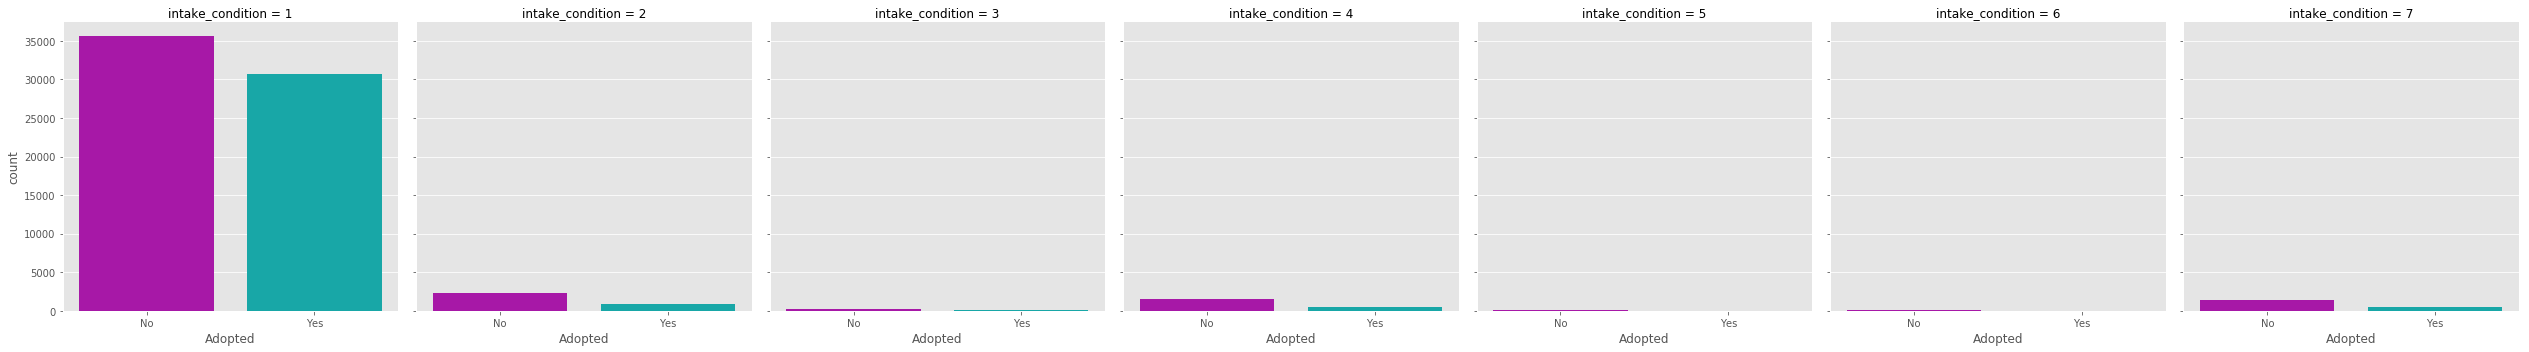

In [242]:
sns.catplot('Adopted', col = 'intake_condition', kind = 'count', data = df, palette=sns.color_palette(['m', 'c']))


#### 'Normal':1,'Injured':2,'Aged':3,'Sick':4,'Other':5,'Feral':6,'Pregnant':7,'Nursing':7

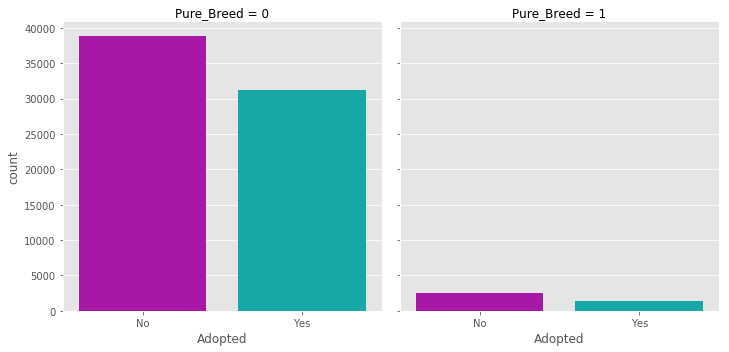

In [243]:
sns.catplot('Adopted', col = 'Pure_Breed', kind = 'count', data = df, palette=sns.color_palette(['m', 'c']))


## Age vs. Time 

Text(0,0.5,'Days Spent in Shelter')

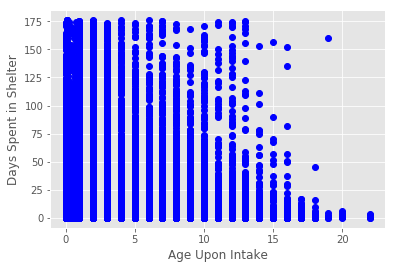

In [244]:
plt.plot(df.age_upon_intake_years,df.time_in_shelter_days,'bo')
plt.xlabel('Age Upon Intake')
plt.ylabel('Days Spent in Shelter')

## Time Spent in Shelter based on groups

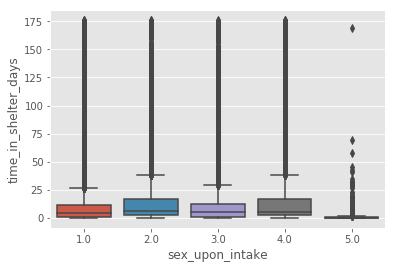

In [245]:
ax = sns.boxplot(x="sex_upon_intake", y="time_in_shelter_days",data=df)

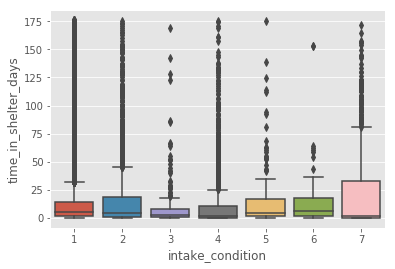

In [246]:
ax = sns.boxplot(x="intake_condition", y="time_in_shelter_days",data=df)

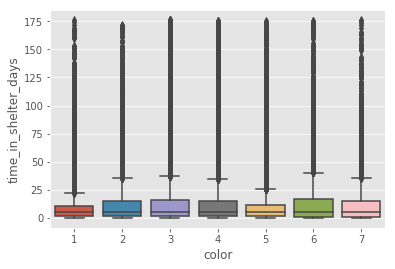

In [247]:
ax = sns.boxplot(x="color", y="time_in_shelter_days",data=df)

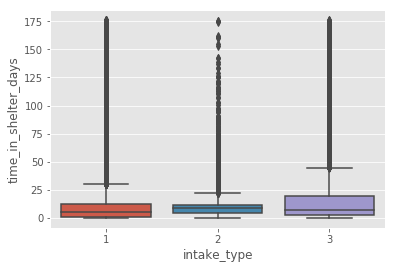

In [248]:
ax = sns.boxplot(x="intake_type", y="time_in_shelter_days",data=df)

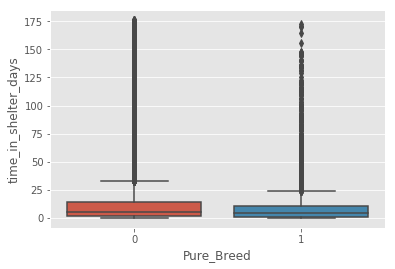

In [249]:
ax = sns.boxplot(x="Pure_Breed", y="time_in_shelter_days",data=df)

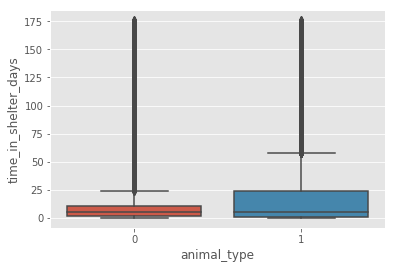

In [250]:
ax = sns.boxplot(x="animal_type", y="time_in_shelter_days",data=df)

## Classification Analysis by Decision Tree

Misclassified samples: 8392
Accuracy: 0.62


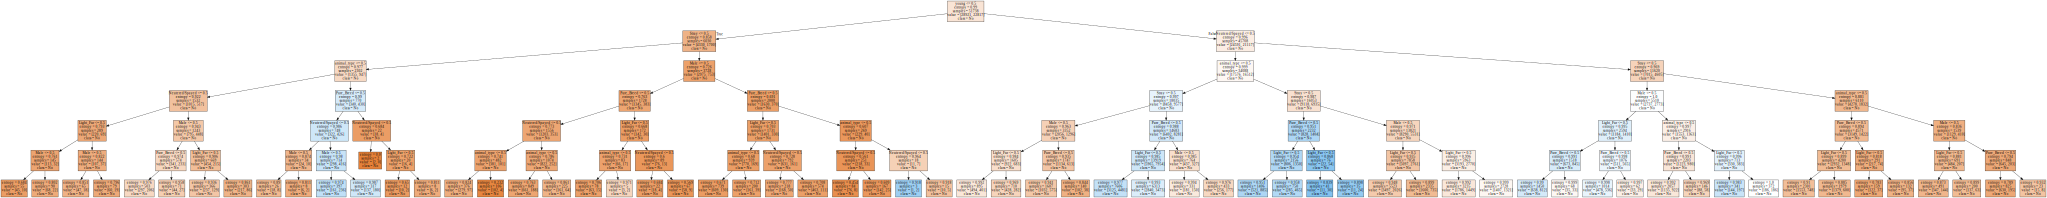

In [259]:
import os
import numpy as np
import pandas as pd
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, metrics
feature_cols = ['animal_type','Male','Neutered/Spayed','young','Healthy','Stray','Light_Fur','Pure_Breed']
X = df[feature_cols] # Features
y = df.Adopted # Target variable
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)
dtree.fit(X_train, y_train)

# use the model to make predictions with the test data
y_pred = dtree.predict(X_test)
# how did our model perform?
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

import graphviz
feature_names = X.columns

dot_data = tree.export_graphviz(dtree, out_file=None, filled=True,
                                feature_names=feature_cols,  
                                class_names=df['Adopted'])
graph = graphviz.Source(dot_data)  
graph

# Outcome of Decision Tree
In the video I didn't get a chance to get deep into the point of the decision tree. Ultimately, each branch splits off into a decision of 'yes' or 'no' and each root node will indicate the ultimate decision of will the animal be adopted or not. This is what the "Class" represents. Mine consisitently led to "Class = No", meaning the factors really didnt have much of a impact between "Adopted = Yes" vs. "Adopted = No". In other words, none of the factors provided an indication on the outcome for that animal.
Also, the entropy did not decrease significantly as each decision was made, meaning there was not a lot of information gained as each node branched off, again indicating that there isn't too much impact of each factor.

## Regression Analysis age vs. time in shelter

##### Although I chose to do classification, I felt that a regression analysis could be interesting for time vs. age

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     time_in_shelter_days   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     87.50
Date:                  Mon, 12 Aug 2019   Prob (F-statistic):           8.63e-21
Time:                          01:56:30   Log-Likelihood:            -3.4044e+05
No. Observations:                 73912   AIC:                         6.809e+05
Df Residuals:                     73910   BIC:                         6.809e+05
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.1986      0.110    137.853      0.000      14.982      15.415
age_upon_intake_years    -0.2858      0.031     -9.354      0.000      -0.346      -0.226
==============================================================================
Omnibus:                    46886.638   Durbin-Watson:                   1.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           470558.249
Skew:                           3.022   Prob(JB):                         0.00
Kurtosis:                      13.783   Cond. No.                         4.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

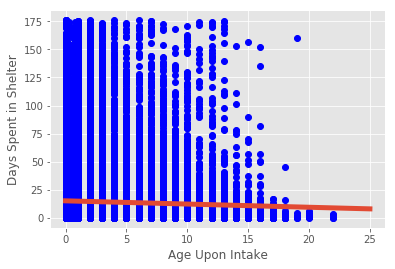

In [225]:
plt.plot(df.age_upon_intake_years, df.time_in_shelter_days, 'bo');
plt.xlabel('Age Upon Intake')
plt.ylabel('Days Spent in Shelter');
model = smf.ols(formula='time_in_shelter_days~age_upon_intake_years', data=df).fit()
beta0,beta1 = model.params
xticks = np.linspace(0,25,5)
plt.plot(xticks, beta0 + beta1 * xticks, lw=5)
model.summary()



## Regression Findings

Again, we don't see an aweful lot of insight from age. Infact, it seems to have an ever so slightly negative correlation, which was surprising. From the model, you can see there is an extremely low r-squared value, again indicating that age does not have a great impact on time spent

# Conclusion


Overall, there really did not appear to be any strong predictive qualities in this study. There doesn't seem to be any factors that hold a strong correlation between the factor and likelihood of being adopted. Furthermore, it doesnt seem as though any of the factors really had a large impact on the amount of time taken for the adoption to occur. At first I was dissapointed that after conducting my study considering I didn't find any real/impactful results, however after thinking about it I suppose that is a good thing that all animals have as much likelihood to be adopted! I also know that Austin happens to a notoriously animal-friendly city, as they strongly promote acceptance of all breeds/sizes, encourage people to bring their animals to bars/restaurants, and most apartments have no weight/breed restrictions. This being said, I am curious if the outcome if different for Austin than it would be for some other cities. That could be an interesting study on its own.